In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.style.use('ggplot')

In [2]:
df = pd.read_csv('/content/quikr_car.csv')

In [ ]:
df.head()

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 892 entries, 0 to 891
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        892 non-null    object
 1   company     892 non-null    object
 2   year        892 non-null    object
 3   Price       892 non-null    object
 4   kms_driven  840 non-null    object
 5   fuel_type   837 non-null    object
dtypes: object(6)
memory usage: 41.9+ KB


In [6]:
backup = df.copy()

#Cleaning Data

## 1. Year


In [7]:
df = df[pd.to_numeric(df['year'], errors='coerce').notnull()]


In [8]:
df['year'] = df['year'].astype(int)


<ipython-input-8-4358701cf1a2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df['year'].astype(int)


## 2. Price


In [9]:
df = df[df['Price'] != 'Ask For Price']


In [10]:
df['Price'] = df['Price'].str.replace(',', '').astype(int)


## 3. kms_driven

In [11]:
df['kms_driven'] = df['kms_driven'].str.split(' ').str[0].str.replace(',', '')
df = df[df['kms_driven'].notna() & df['kms_driven'].str.isnumeric()]
df['kms_driven'] = df['kms_driven'].astype(int)

<ipython-input-11-64043c04d910>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['kms_driven'] = df['kms_driven'].astype(int)


## 4. fuel_type

In [12]:
df = df[df['fuel_type'].notna()]


## 5. Name


In [14]:
def keep_first_three_words(name):
    words = name.split()
    return ' '.join(words[:3])

df['name'] = df['name'].apply(keep_first_three_words)

In [15]:
df.reset_index(drop=True, inplace=True)

# Cleaned Data

In [20]:
df.to_csv('Cleaned_Car_data.csv')

In [ ]:
df.info()

In [24]:
df.describe(include='all')

,name,company,year,Price,kms_driven,fuel_type
count,816,816,816.000000,8.160000e+02,816.000000,816
unique,254,25,NaN,NaN,NaN,3
top,Maruti Suzuki Swift,Maruti,NaN,NaN,NaN,Petrol
freq,51,221,NaN,NaN,NaN,428
mean,NaN,NaN,2012.444853,4.117176e+05,46275.531863,NaN
std,NaN,NaN,4.002992,4.751844e+05,34297.428044,NaN
min,NaN,NaN,1995.000000,3.000000e+04,0.000000,NaN
25%,NaN,NaN,2010.000000,1.750000e+05,27000.000000,NaN
50%,NaN,NaN,2013.000000,2.999990e+05,41000.000000,NaN
75%,NaN,NaN,2015.000000,4.912500e+05,56818.500000,NaN


# Data Visualization

## 1. Price vs Year

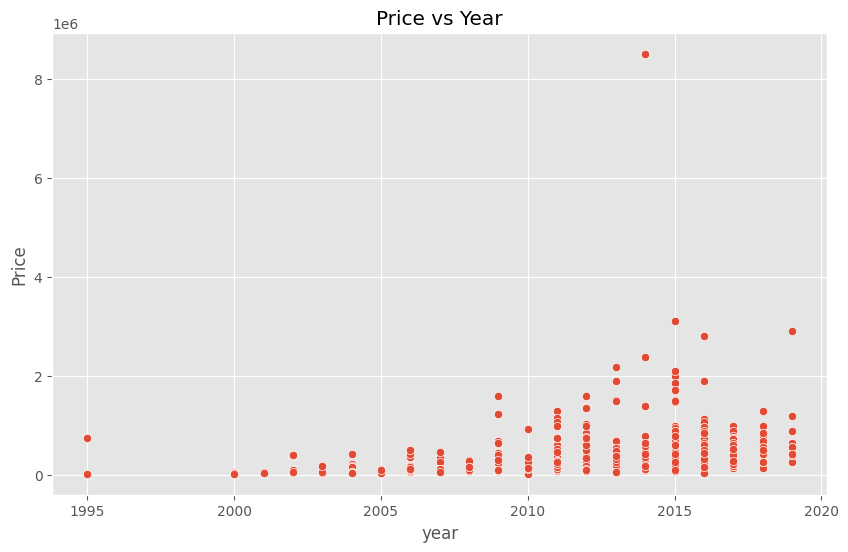

In [37]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='year', y='Price', data=df)
plt.title('Price vs Year')
plt.show()

## 2. Price vs Company

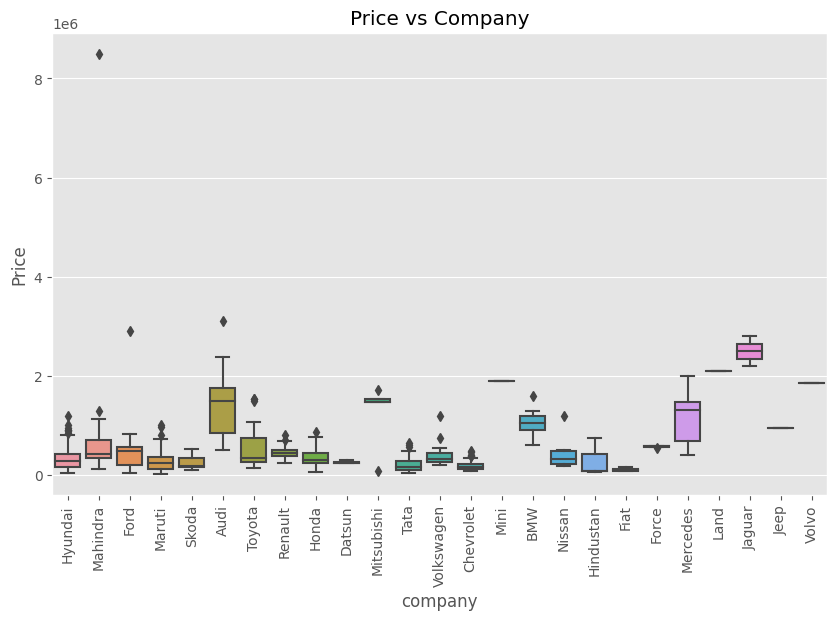

In [30]:
plt.figure(figsize=(10,6))
sns.boxplot(x='company', y='Price', data=df)
plt.xticks(rotation=90)
plt.title('Price vs Company')
plt.show()

## 3. Price vs kms_driven

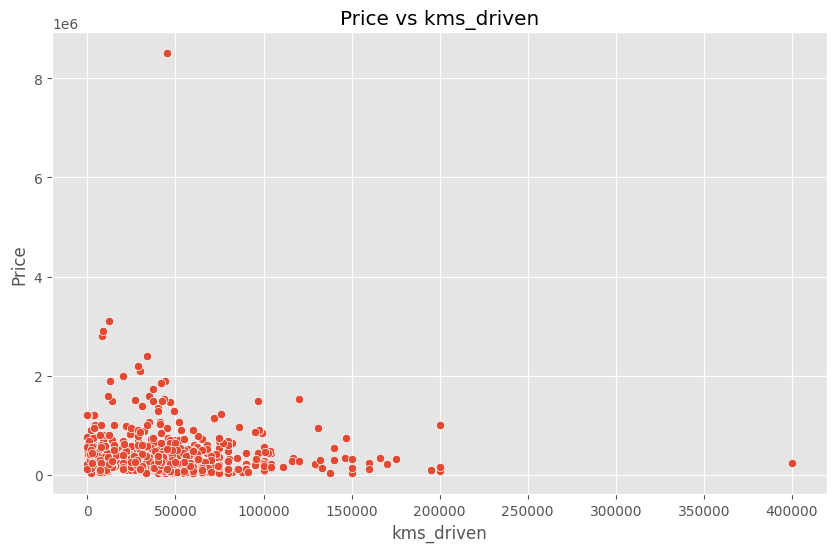

In [33]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='kms_driven', y='Price', data=df)
plt.title('Price vs kms_driven')
plt.show()

## 4. Price vs fuel_type

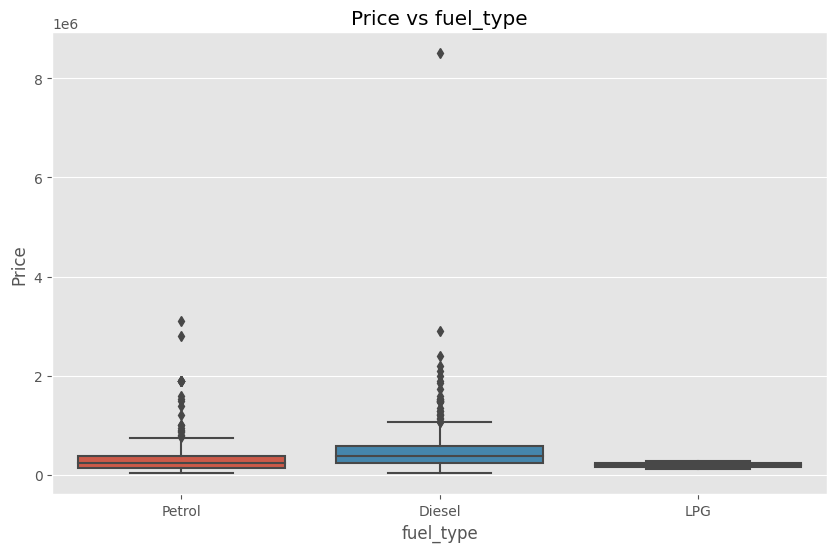

In [36]:
plt.figure(figsize=(10,6))
sns.boxplot(x='fuel_type', y='Price', data=df)
plt.title('Price vs fuel_type')
plt.show()

# Model Building

In [52]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [48]:
X = df.drop('Price', axis=1)
y = df['Price']

In [49]:
ohe = OneHotEncoder()
ohe.fit(X[['name','company','fuel_type']])
column_trans = make_column_transformer((OneHotEncoder(categories=ohe.categories_),['name','company','fuel_type']), remainder='passthrough')


In [53]:
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

In [56]:
for model_name, model in models.items():
    scores = []
    for i in range(100):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)
        pipe = make_pipeline(column_trans, model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        scores.append(r2_score(y_test, y_pred))

In [59]:
best_random_state = np.argmax(scores)
best_score = scores[best_random_state]
print(f"Best r2_score for {model_name}: {best_score} with random_state: {best_random_state}")

Best r2_score for Gradient Boosting: 0.8516967667020356 with random_state: 52


In [61]:
import pickle

In [62]:
pickle.dump(pipe,open('Car_price_best_model.pkl','wb'))